In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets
!pip install --upgrade sympy
!pip install --upgrade datasets
!pip install evaluate
!pip install transformers
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uni

In [3]:
import zipfile
import os

# ZIP 파일 경로
zip_path = "/content/drive/MyDrive/Assignments/심신개/car_damage_data_v.zip"
output_dir = "/content/car_damage_data_v"  # ZIP 파일을 풀 디렉토리

# ZIP 파일 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"ZIP 파일이 해제되었습니다: {output_dir}")

ZIP 파일이 해제되었습니다: /content/car_damage_data_v


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 데이터 폴더 경로 설정
base_dir = 'car_damage_data_v'
valid_dir = os.path.join(base_dir, 'valid')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# valid 폴더에서 image와 label 디렉토리 가져오기
valid_image_dir = os.path.join(valid_dir, 'image')
valid_label_dir = os.path.join(valid_dir, 'label')

# train, test, valid 폴더 내 image와 label 디렉토리 생성
for split in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(base_dir, split, 'image'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'label'), exist_ok=True)

# valid 폴더 내 파일 리스트 가져오기
images = sorted(os.listdir(valid_image_dir))
labels = sorted(os.listdir(valid_label_dir))

# 이미지와 라벨 파일 매칭
assert len(images) == len(labels), "이미지와 라벨의 개수가 일치하지 않습니다."
data_pairs = list(zip(images, labels))

# 데이터를 7:1.5:1.5로 나누기
train_pairs, temp_pairs = train_test_split(data_pairs, test_size=0.3, random_state=42)
valid_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# Helper 함수: 파일 이동
def move_files(pairs, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
    for image_file, label_file in pairs:
        # 이미지 파일 이동
        shutil.move(os.path.join(src_image_dir, image_file), os.path.join(dest_image_dir, image_file))
        # 라벨 파일 이동
        shutil.move(os.path.join(src_label_dir, label_file), os.path.join(dest_label_dir, label_file))

# train, valid, test 폴더로 데이터 이동
move_files(train_pairs, valid_image_dir, valid_label_dir,
           os.path.join(train_dir, 'image'), os.path.join(train_dir, 'label'))

move_files(valid_pairs, valid_image_dir, valid_label_dir,
           os.path.join(valid_dir, 'image'), os.path.join(valid_dir, 'label'))

move_files(test_pairs, valid_image_dir, valid_label_dir,
           os.path.join(test_dir, 'image'), os.path.join(test_dir, 'label'))

print("데이터 분할 완료!")

데이터 분할 완료!


In [5]:
import os
import json
from PIL import Image, ImageDraw
from tqdm import tqdm # 진행 상황 표시

# 데이터셋의 상위 디렉토리와 출력 디렉토리 설정
dataset_dir = "/content/car_damage_data_v"
output_base_dir = "/content/car_damage_data_v/masks"
os.makedirs(output_base_dir, exist_ok=True)

# 데이터셋의 train, valid, test 각각 처리
for split in ["train", "valid", "test"]:
    # JSON 파일이 있는 디렉토리
    json_dir = os.path.join(dataset_dir, split, "label")
    if not os.path.exists(json_dir):
        print(f"{split} 디렉토리가 없습니다: {json_dir}")
        continue

    # 마스크 저장 디렉토리
    output_dir = os.path.join(output_base_dir, split)
    os.makedirs(output_dir, exist_ok=True)

    # JSON 디렉토리 순회
    for json_file in tqdm(os.listdir(json_dir), desc=f"Processing {split}"):
        if not json_file.endswith(".json"):
            continue  # JSON 파일만 처리

        # JSON 파일 경로
        json_path = os.path.join(json_dir, json_file)

        # JSON 데이터 로드
        with open(json_path, "r") as f:
            data = json.load(f)

        # 이미지 정보 가져오기
        image_info = data["images"]
        image_width, image_height = image_info["width"], image_info["height"]
        image_file = image_info["file_name"]

        # 빈 마스크 생성 (배경은 0으로 설정)
        mask = Image.new("L", (image_width, image_height), 0)  # "L"은 흑백 이미지를 의미
        draw = ImageDraw.Draw(mask)

        # 어노테이션 처리
        for ann in data["annotations"]:
            # "damage"가 있으면 1로 처리
            if "damage" in ann and ann["damage"] is not None:
                segmentation = ann["segmentation"][0][0]  # 다각형 좌표
                polygons = [tuple(point) for point in segmentation]  # (x, y) 튜플로 변환

                # "damage" 부분만 1로 표시
                draw.polygon(polygons, fill=1)  # damage 부분을 1로 채우기

        # 마스크 저장
        mask_output_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_mask.png")
        mask.save(mask_output_path)

Processing test: 100%|██████████| 1514/1514 [00:08<00:00, 169.18it/s]


In [6]:
import os
from datasets import Dataset
from transformers import DPTForSemanticSegmentation, DPTImageProcessor, TrainingArguments, Trainer
import torch
from PIL import Image
import numpy as np

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 함수
def load_data(images_dir, masks_dir):
    images = sorted(os.listdir(images_dir))
    masks = sorted(os.listdir(masks_dir))
    data = []
    for img_name, mask_name in zip(images, masks):
        image_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)
        data.append({"image": image_path, "mask": mask_path})
    return data

# 전처리 함수
def preprocess(example):
    image = Image.open(example["image"]).convert("RGB").resize((512, 512))  # Resizing to 512x512
    mask = Image.open(example["mask"]).resize((512, 512))                   # Resizing to 512x512
    encoding = processor(image, return_tensors="pt")
    mask = np.array(mask)
    mask = mask - mask.min()  # Ensure mask values start from 0
    mask = torch.tensor(mask, dtype=torch.long)
    return {"pixel_values": encoding["pixel_values"].squeeze(0), "labels": mask}


# 데이터 경로
train_images_dir = "/content/car_damage_data_v/train/image"
train_masks_dir = "/content/car_damage_data_v/masks/train"
val_images_dir = "/content/car_damage_data_v/valid/image"
val_masks_dir = "/content/car_damage_data_v/masks/valid"

train_data = load_data(train_images_dir, train_masks_dir)
val_data = load_data(val_images_dir, val_masks_dir)

# DPT 모델 및 프로세서 로드
model_name = "Intel/dpt-hybrid-midas"
processor = DPTImageProcessor.from_pretrained(model_name)

# DPT 모델 로드 및 최종 레이어 수정
model = DPTForSemanticSegmentation.from_pretrained(
    model_name,
    ignore_mismatched_sizes=True  # 크기 불일치 무시
)
model.head.head[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))  # num_labels=2 설정
model.to(device)

# 데이터셋 변환
train_dataset = Dataset.from_list(train_data).map(preprocess)
val_dataset = Dataset.from_list(val_data).map(preprocess)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-hybrid-midas and are newly initialized: ['auxiliary_head.head.0.weight', 'auxiliary_head.head.1.bias', 'auxiliary_head.head.1.num_batches_tracked', 'auxiliary_head.head.1.running_mean', 'auxiliary_head.head.1.running_var', 'auxiliary_head.head.1.weight', 'auxiliary_head.head.4.bias', 'auxiliary_head.head.4.weight', 'head.head.1.bias', 'head.head.1.num_batches_tracked', 'head.head.1.running_mean', 'head.head.1.running_var', 'head.head.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-hybrid-midas and are newly initialized because the shapes did not match:
- head.head.0.weight: found shape torch.Size([128, 256, 3, 3]) in the checkpoint and torch.Size([256, 256, 3, 3]) in the model instantiated
- head.head.4.weight:

Map:   0%|          | 0/7062 [00:00<?, ? examples/s]

Map:   0%|          | 0/1513 [00:00<?, ? examples/s]

In [7]:
print(model.head.head[4])

Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))


In [8]:
from torchmetrics.classification import BinaryJaccardIndex, Dice

# IoU와 Dice 계수 정의
# Evaluation Metrics
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")
id2label = {
    0: "background",  # 클래스 ID 0은 "background"라는 의미
    1: "damage"       # 클래스 ID 1은 "damage"라는 의미
}
def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=len(id2label),
        ignore_index=None,
        reduce_labels=False,  # 필요에 따라 True로 설정
    )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics


# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./drive/MyDrive/saved_model",  # 로그 파일과 결과만 저장
    evaluation_strategy="steps",             # 평가 주기 설정
    eval_steps=500,
    save_steps=0,                            # 체크포인트 저장 비활성화
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",                    # 로그 디렉토리 설정
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=False,            # 최적 모델 로드 비활성화
    learning_rate=5e-5,
)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 학습 시작
trainer.train()

# 최종 평가
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Damage,Iou Background,Iou Damage
500,0.646500,0.446323,0.575853,0.634386,0.919930,0.977479,0.291292,0.917925,0.233780
1000,0.273100,0.249788,0.670978,0.752099,0.935662,0.972658,0.531541,0.932661,0.409296
1500,0.251900,0.234205,0.649165,0.697965,0.939464,0.988136,0.407795,0.937321,0.361010
2000,0.217200,0.216333,0.682363,0.741237,0.943197,0.983901,0.498572,0.940719,0.424007
2500,0.200400,0.211627,0.683486,0.740955,0.943730,0.984598,0.497312,0.941281,0.425691
3000,0.202900,0.206183,0.675524,0.721717,0.944883,0.989860,0.453575,0.942703,0.408344
3500,0.168700,0.197508,0.705897,0.770416,0.946685,0.982210,0.558622,0.944064,0.467730
4000,0.167800,0.203783,0.705881,0.761898,0.948283,0.985848,0.537949,0.945840,0.465921
4500,0.152400,0.196724,0.710252,0.771005,0.948231,0.983950,0.558060,0.945690,0.474814
5000,0.141100,0.199316,0.708558,0.764088,0.948874,0.986116,0.542059,0.946439,0.470677


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


{'eval_loss': 0.19400976598262787, 'eval_mean_iou': 0.7177038063801802, 'eval_mean_accuracy': 0.7806106754065769, 'eval_overall_accuracy': 0.9492885768610518, 'eval_accuracy_background': 0.9832841641267306, 'eval_accuracy_damage': 0.5779371866864234, 'eval_iou_background': 0.9467053667842635, 'eval_iou_damage': 0.48870224597609685, 'eval_runtime': 761.0916, 'eval_samples_per_second': 1.988, 'eval_steps_per_second': 0.498, 'epoch': 3.0}


In [9]:
# # Google Drive 내 저장 경로 설정
# save_directory = "/content/drive/MyDrive/Assignments/심심개/DPT-model"

# # 모델 저장
# trainer.save_model(save_directory)

# # 프로세서 저장
# processor.save_pretrained(save_directory)

# # 수정된 head 가중치 저장
# head_weights_path = os.path.join(save_directory, "head_weights.pt")
# torch.save(model.head.state_dict(), head_weights_path)

# print(f"Model, processor, and head weights saved in {save_directory}")

Model, processor, and head weights saved in /content/drive/MyDrive/Assignments/심심개/DPT-model


In [18]:
from transformers import DPTForSemanticSegmentation, DPTImageProcessor

# 저장된 경로
saved_model_path = "/content/drive/MyDrive/Assignments/심심개/DPT-model"

# 모델 로드 (크기 불일치 무시)
model_eval = DPTForSemanticSegmentation.from_pretrained(
    saved_model_path,
    num_labels=2,  # 수정된 head의 레이블 수와 일치
    ignore_mismatched_sizes=True
)
head_weights_path = os.path.join(saved_model_path, "head_weights.pt")
# 수정된 head 가중치 로드
model_eval.head.load_state_dict(torch.load(head_weights_path))  # num_labels=2 설정

model_eval.eval()  # 예측 모드로 전환

# 프로세서 로드
processor_eval = DPTImageProcessor.from_pretrained(saved_model_path)

print("Model and processor successfully loaded!")

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at /content/drive/MyDrive/Assignments/심심개/DPT-model and are newly initialized because the shapes did not match:
- auxiliary_head.head.4.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.head.4.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and processor successfully loaded!


<ipython-input-18-dca181330556>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_eval.head.load_state_dict(torch.load(head_weights_path))  # num_labels=2 설정


In [19]:
def predict_segmentation(image_path):
    from PIL import Image
    import torch
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_eval.to(device)

    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB").resize((512, 512))
    inputs = processor_eval(image, return_tensors="pt").to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model_eval(**inputs)
        logits = outputs.logits
        # logits = logits[:, [1, 0], :, :]
        preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
    return preds

predict_segmentation("/content/car_damage_data_v/test/image/0506262_as-9091727.jpg")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

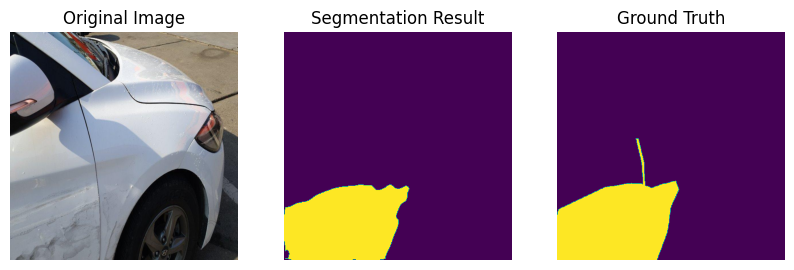

In [21]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 테스트 이미지 경로
test_image_path = "/content/car_damage_data_v/test/image/0509195_sc-201067.jpg"  # 테스트할 이미지 경로
ground_truth_path = "/content/car_damage_data_v/masks/test/0509195_sc-201067_mask.png"  # 테스트할 이미지의 ground truth 경로
prediction = predict_segmentation(test_image_path)
ground_truth = Image.open(ground_truth_path).resize((512, 512))  # ground truth 이미지 크기 조정

# 결과 시각화
def visualize_results(image_path, prediction):
    image = Image.open(image_path).convert("RGB").resize((512, 512))  # 원본 이미지와 동일 크기
    plt.figure(figsize=(10, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # 예측 결과
    plt.subplot(1, 3, 2)
    plt.title("Segmentation Result")
    plt.imshow(prediction, cmap='viridis')  # 예측 클래스 맵 시각화
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='viridis')  # 예측 클래스 맵 시각화
    plt.axis("off")

    plt.show()

# 시각화 실행
visualize_results(test_image_path, prediction)

In [22]:

# 데이터 경로
test_images_dir = "/content/car_damage_data_v/test/image"
test_masks_dir = "/content/car_damage_data_v/masks/test"

test_data = load_data(test_images_dir, test_masks_dir)

# 데이터셋 변환
test_dataset = Dataset.from_list(test_data).map(preprocess)

Map:   0%|          | 0/1514 [00:00<?, ? examples/s]

In [23]:
from torch.nn.functional import interpolate

def evaluate_on_test_dataset(model, test_dataset):
    model.eval()  # 모델을 평가 모드로 전환
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_predictions = []
    all_references = []

    for example in tqdm(test_dataset, desc="Evaluating test dataset"):
        # 이미지와 라벨 가져오기 (텐서로 변환)
        image = torch.tensor(example["pixel_values"]).to(device)  # 강제 변환
        label = torch.tensor(example["labels"]).to(device)        # 강제 변환

        # 모델 예측
        with torch.no_grad():
            outputs = model(image.unsqueeze(0))  # 배치 차원 추가
            preds = torch.argmax(outputs.logits, dim=1)  # [1, H, W]

            # preds 크기를 label 크기로 리사이즈
            preds_resized = interpolate(
                preds.float().unsqueeze(1),  # [N, C=1, H, W]로 확장
                size=label.shape,
                mode="nearest"
            ).squeeze(1)  # [N, H, W]로 다시 축소

        # 결과 저장
        all_predictions.append(preds_resized.squeeze(0).cpu().numpy())
        all_references.append(label.cpu().numpy())

    # IoU 계산
    metrics = metric.compute(
        predictions=all_predictions,
        references=all_references,
        num_labels=len(id2label),
        ignore_index=None,
        reduce_labels=False
    )

    print("\nTest Dataset Evaluation Results:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    return metrics
evaluate_on_test_dataset(model_eval, test_dataset)

Evaluating test dataset: 100%|██████████| 1514/1514 [11:06<00:00,  2.27it/s]
/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")



Test Dataset Evaluation Results:
mean_iou: 0.7051949536074176
mean_accuracy: 0.7653847550384815
overall_accuracy: 0.9468298575679723
per_category_iou: [0.94424113 0.46614878]
per_category_accuracy: [0.98394211 0.5468274 ]


{'mean_iou': 0.7051949536074176,
 'mean_accuracy': 0.7653847550384815,
 'overall_accuracy': 0.9468298575679723,
 'per_category_iou': array([0.94424113, 0.46614878]),
 'per_category_accuracy': array([0.98394211, 0.5468274 ])}

In [24]:
# 총 파라미터와 학습 가능한 파라미터 계산 및 출력
total_params = sum(p.numel() for p in model_eval.parameters())
trainable_params = sum(p.numel() for p in model_eval.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 123,227,716
Trainable parameters: 123,227,716
